<a href="https://colab.research.google.com/github/SushiBanana/AccidentAnalysis/blob/main/AccidentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 4.1 Research Question


To what extent do passenger and driver behaviours and demographics, including seat belt and helmet use, vehicle manoeuvres prior to accident, seating position, age and gender, influence injury outcomes in Victorian road accidents?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import required modules

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statistics

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

Read in relevant csvs

In [ ]:
vehicle_df = pd.read_csv('/content/drive/MyDrive/EoDP/vehicle.csv', usecols = ['ACCIDENT_NO', 'VEHICLE_ID', 'VEHICLE_MOVEMENT'])
person_df = pd.read_csv('/content/drive/MyDrive/EoDP/person.csv', usecols = ['ACCIDENT_NO', 'VEHICLE_ID', 'HELMET_BELT_WORN',
                                                                             'SEATING_POSITION', 'SEX', 'AGE_GROUP', 'INJ_LEVEL', 'INJ_LEVEL_DESC'])

### 4.2 Data Pre-processing Component
Pre-processing Passenger and Driver Demographics (Sex, Age) and Behaviours (Vehicle Movement, Helmet/Seatbelt use, Seating Position)

##### Merging vehicle and person DataFrames

In [ ]:
# Merge vehicles persons on both ACCIDENT_NO and VEHICLE_ID (ensures correct matching)
merged_df = vehicle_df.merge(person_df, on=['ACCIDENT_NO', 'VEHICLE_ID'], how='inner')

##### Remove rows with missing values and convert vehicle movement into integer

In [ ]:
# Get rid of rows with missing values
merged_df.dropna(inplace=True)

# Remove unknown or not-applicable values
merged_df = merged_df[
    (merged_df['VEHICLE_MOVEMENT'] != 99) &
    (merged_df['HELMET_BELT_WORN'] != 9) &
    (merged_df['SEATING_POSITION'].astype(str) != 'NA') &
    (merged_df['AGE_GROUP'].astype(str) != 'Unknown') &
    (merged_df['SEX'].astype(str) != 'U') &
    (merged_df['SEATING_POSITION'].astype(str) != 'NK')
]

# Convert VEHICLE_MOVEMENT to integer
merged_df['VEHICLE_MOVEMENT'] = merged_df['VEHICLE_MOVEMENT'].astype(int)

<ipython-input-345-1a3cf43cebdd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['VEHICLE_MOVEMENT'] = merged_df['VEHICLE_MOVEMENT'].astype(int)


Function to find the median age given the age group

In [ ]:
def find_median_age(age_group):
  ages = age_group.split('-')
  ages = [int(age) for age in ages]
  return statistics.median(ages)

##### Encode categorical data and expand abbreviations

In [ ]:
# Convert Injury level integers into an index, where higher number -> more severe injury
injury_weights = {1: 3, 2: 2, 3: 1, 4: 0}

# Add movement descriptions
vehicle_movement_map = {
    1: 'Going straight ahead',
    2: 'Turning right',
    3: 'Turning left',
    4: 'Leaving a driveway',
    5: 'U-turning',
    6: 'Changing lanes',
    7: 'Overtaking',
    8: 'Merging',
    9: 'Reversing',
    10: 'Parking/unparking',
    11: 'Parked legally',
    12: 'Parked illegally',
    13: 'Stationary accident',
    14: 'Stationary broken down',
    15: 'Other stationary',
    16: 'Avoiding animals',
    17: 'Slow/stopping',
    18: 'Out of control',
    19: 'Wrong way'
}

# Add impact descriptions
helmet_belt_map = {
    1: 'Seatbelt worn',
    2: 'Seatbelt not worn',
    3: 'Child restraint worn',
    4: 'Child restraint not worn',
    5: 'Seatbelt/restraint not fitted',
    6: 'Crash helmet worn',
    7: 'Crash helmet not worn',
    8: 'Not appropriate',
    9: 'Not known'
}

# Convert behaviour into numerical format
behaviour_map = {
    'Reckless behaviour': 2,
    'Safe behaviour': 1
}

# Add seating position description
seating_position_map = {
    'CF': 'Centre-front',
    'CR': 'Centre-rear',
    'D': 'Driver/Rider',
    'LF': 'Left-front',
    'LR': 'Left-rear',
    'NK': 'Not known',
    'OR': 'Other-rear',
    'PL': 'Pillion passenger',
    'PS': 'Motorcycle sidecar passenger',
    'RR': 'Right-rear'
}

# Convert seating position into numerical format
seating_position_num_map = {
    'CF': 1,
    'CR': 2,
    'D': 3,
    'LF': 4,
    'LR': 5,
    'NA': 6,
    'NK': 7,
    'OR': 8,
    'PL': 9,
    'PS': 10,
    'RR': 11
}

# All age groups, except '70+'
age_groups = ['0-4', '5-12', '13-15', '16-17', '18-21', '22-25', '26-29', '30-39', '40-49', '50-59', '60-64', '65-69']
age_group_map = {age: find_median_age(age) for age in age_groups}

age_group_map['70+'] = 70

sex_group_map = {
    'M': 1,
    'F': 2,
    'U': 3
}

Apply predefined mappings

In [ ]:
merged_df['INJ_LEVEL'] = merged_df['INJ_LEVEL'].map(injury_weights)
merged_df['HELMET_BELT_DESC'] = merged_df['HELMET_BELT_WORN'].map(helmet_belt_map)
merged_df['VEHICLE_MOVEMENT_DESC'] = merged_df['VEHICLE_MOVEMENT'].map(vehicle_movement_map)
merged_df['SEATING_POSITION_NUM'] = merged_df['SEATING_POSITION'].map(seating_position_num_map)
merged_df['SEATING_POSITION_DESC'] = merged_df['SEATING_POSITION'].map(seating_position_map)
merged_df['SEX_NUM'] = merged_df['SEX'].map(sex_group_map)
merged_df['AGE_GROUP_NUM'] = merged_df['AGE_GROUP'].map(age_group_map)

<ipython-input-348-2f4db83ddbcb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['INJ_LEVEL'] = merged_df['INJ_LEVEL'].map(injury_weights)
<ipython-input-348-2f4db83ddbcb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['HELMET_BELT_DESC'] = merged_df['HELMET_BELT_WORN'].map(helmet_belt_map)
<ipython-input-348-2f4db83ddbcb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

##### Categorise vehicle movement and helmet/belt statuses into Safe/Reckless behaviour

In [ ]:
# Define safe and unsafe vehicle movements
reckless_movements = {
    'Wrong way',
    'Out of control',
    'Overtaking',
    'Avoiding animals',
    'Parked illegally',
    'Stationary accident',
    'Stationary broken down'
}

# Categorise vehicle movement as safe/unsafe
merged_df['VEHICLE_BEHAVIOUR'] = merged_df['VEHICLE_MOVEMENT_DESC'].apply(
    lambda x: 'Reckless behaviour' if x in reckless_movements else 'Safe behaviour'
)


merged_df['VEHICLE_BEHAVIOUR_NUM'] = merged_df['VEHICLE_BEHAVIOUR'].map(behaviour_map)

# Define safe and unsafe helmet/belt statuses
safe_helmet_belt = {
    'Seatbelt worn',
    'Child restraint worn',
    'Crash helmet worn'
}

# Categorise helmet/belt use as safe/unsafe
merged_df['HELMET_BELT_BEHAVIOUR'] = merged_df['HELMET_BELT_DESC'].apply(
    lambda x: 'Safe behaviour' if x in safe_helmet_belt else 'Reckless behaviour'
)

merged_df['HELMET_BELT_BEHAVIOUR_NUM'] = merged_df['HELMET_BELT_BEHAVIOUR'].map(behaviour_map)

Convert cleaned data into csv file

In [ ]:
merged_df.to_csv('cleaned_accident_data.csv', index=False)

In [ ]:
merged_df

,ACCIDENT_NO,VEHICLE_ID,VEHICLE_MOVEMENT,SEX,AGE_GROUP,INJ_LEVEL,INJ_LEVEL_DESC,SEATING_POSITION,HELMET_BELT_WORN,HELMET_BELT_DESC,VEHICLE_MOVEMENT_DESC,SEATING_POSITION_NUM,SEATING_POSITION_DESC,SEX_NUM,AGE_GROUP_NUM,VEHICLE_BEHAVIOUR,VEHICLE_BEHAVIOUR_NUM,HELMET_BELT_BEHAVIOUR,HELMET_BELT_BEHAVIOUR_NUM
0,T20120000009,A,18,M,18-21,1,Other injury,LF,1.0,Seatbelt worn,Out of control,4,Left-front,1,19.5,Reckless behaviour,2,Safe behaviour,1
1,T20120000009,A,18,M,18-21,1,Other injury,D,1.0,Seatbelt worn,Out of control,3,Driver/Rider,1,19.5,Reckless behaviour,2,Safe behaviour,1
4,T20120000012,B,1,M,60-64,2,Serious injury,D,1.0,Seatbelt worn,Going straight ahead,3,Driver/Rider,1,62.0,Safe behaviour,1,Safe behaviour,1
5,T20120000013,A,18,F,26-29,2,Serious injury,D,1.0,Seatbelt worn,Out of control,3,Driver/Rider,2,27.5,Reckless behaviour,2,Safe behaviour,1
6,T20120000018,A,18,M,30-39,1,Other injury,D,1.0,Seatbelt worn,Out of control,3,Driver/Rider,1,34.5,Reckless behaviour,2,Safe behaviour,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400840,T20250000469,B,17,F,22-25,0,Not injured,D,1.0,Seatbelt worn,Slow/stopping,3,Driver/Rider,2,23.5,Safe behaviour,1,Safe behaviour,1
400851,T20250001075,A,6,M,70+,0,Not injured,D,1.0,Seatbelt worn,Changing lanes,3,Driver/Rider,1,70.0,Safe behaviour,1,Safe behaviour,1
400852,T20250001075,B,1,M,22-25,1,Other injury,D,1.0,Seatbelt worn,Going straight ahead,3,Driver/Rider,1,23.5,Safe behaviour,1,Safe behaviour,1
400853,T20250001671,A,1,F,50-59,1,Other injury,D,1.0,Seatbelt worn,Going straight ahead,3,Driver/Rider,2,54.5,Safe behaviour,1,Safe behaviour,1


### 4.3 Correlation and Causal Analysis Component

#### General Correlation

Create a DataFrame with all relevant variables

In [ ]:
axis_labels = {
    'VEHICLE_BEHAVIOUR_NUM': 'Vehicle Behaviour',
    'HELMET_BELT_BEHAVIOUR_NUM': 'Helmet/Seatbelt Behaviour',
    'SEATING_POSITION_NUM': 'Seating Position',
    'SEX_NUM': 'Sex',
    'AGE_GROUP_NUM': 'Age Group',
    'INJ_LEVEL': 'Injury Level'
}

heatmap_df = merged_df[['VEHICLE_BEHAVIOUR_NUM',
                        'HELMET_BELT_BEHAVIOUR_NUM',
                        'SEATING_POSITION_NUM',
                        'INJ_LEVEL',
                        'SEX_NUM',
                        'AGE_GROUP_NUM']].copy()

##### Part 1: Pearson correlation matrix

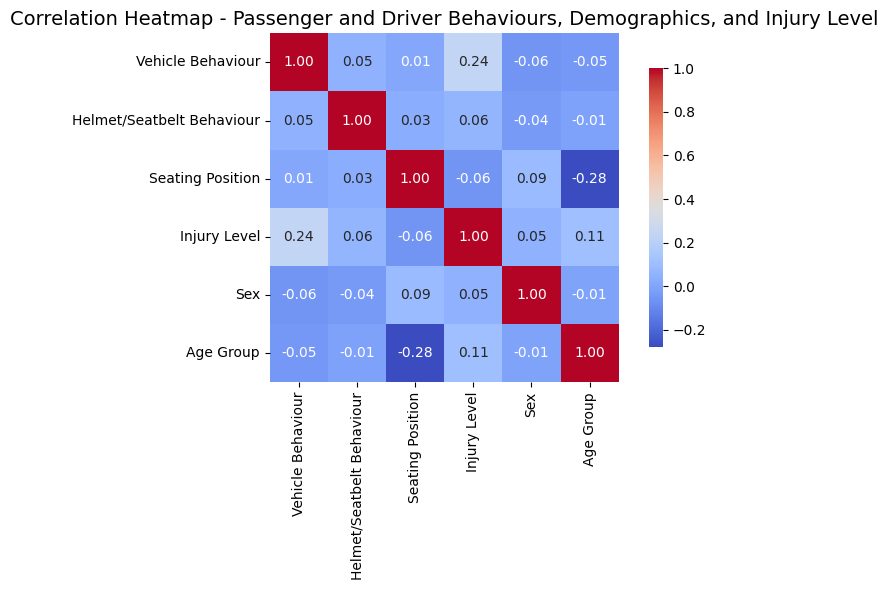

In [ ]:
corr_matrix = heatmap_df.corr()

# Rename axis labels
corr_matrix.rename(index=axis_labels, columns=axis_labels, inplace=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Passenger and Driver Behaviours, Demographics, and Injury Level', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Part 2: Bar heatmap - Ranked Independent variables vs Injury Levels

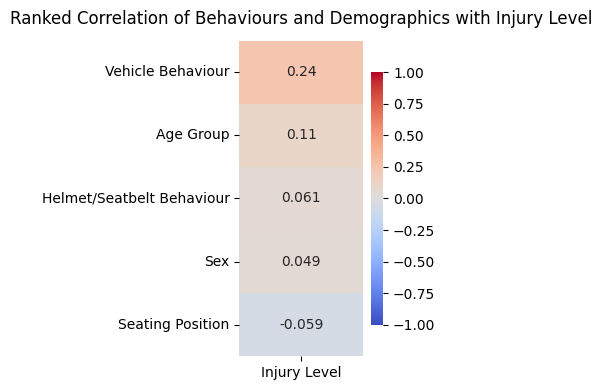

In [ ]:
# Create correlation DataFrame sorted by 'INJ_LEVEL'
target_corr = heatmap_df.corr()[['INJ_LEVEL']].drop('INJ_LEVEL').sort_values(by='INJ_LEVEL', ascending=False)

target_corr.rename(index=axis_labels, columns={'INJ_LEVEL':'Injury Level'}, inplace=True)

# Plot as a vertical single-column heatmap (like your example)
plt.figure(figsize=(4, 4))
sns.heatmap(target_corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm', cbar_kws={"shrink": 0.8})
plt.title('Ranked Correlation of Behaviours and Demographics with Injury Level', fontdict={'fontsize': 12}, pad=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Specific Correlations

##### Part 3: Bar heatmap - Vehicle Movements vs Injury Levels

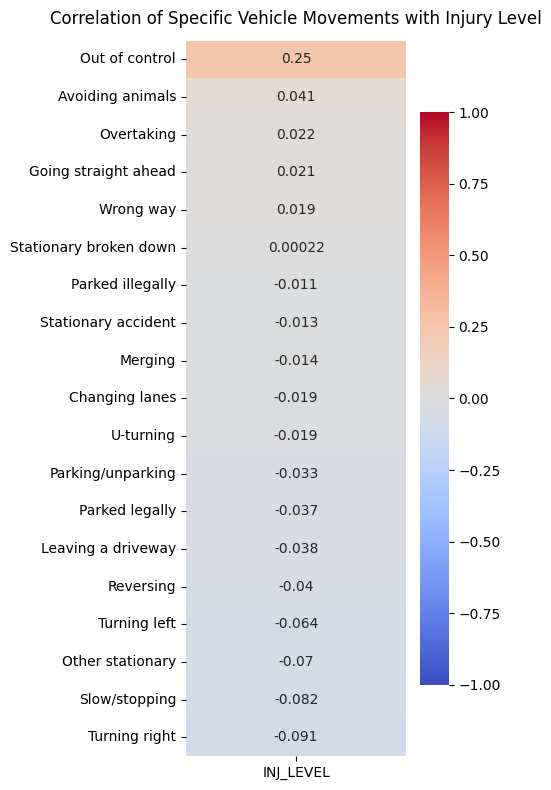

In [ ]:
# One-hot encode VEHICLE_MOVEMENT
movement_encoded = pd.get_dummies(merged_df['VEHICLE_MOVEMENT'], prefix='Movement')

# Combine with INJ_LEVEL
movement_injury_df = pd.concat([movement_encoded, merged_df['INJ_LEVEL']], axis=1)

# Calculate correlation of each movement with INJ_LEVEL
movement_corr = movement_injury_df.corr()['INJ_LEVEL'].drop('INJ_LEVEL').sort_values(ascending=False)

# Map code to description for readability
movement_corr.index = [vehicle_movement_map[int(col.split('_')[1])] for col in movement_corr.index]


# Plot heatmap (bar-style heatmap)
plt.figure(figsize=(5, 8))
sns.heatmap(movement_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation of Specific Vehicle Movements with Injury Level', fontsize=12, pad=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Part 4: Bar heatmap - Belts/Helmets Worn vs Injury Levels

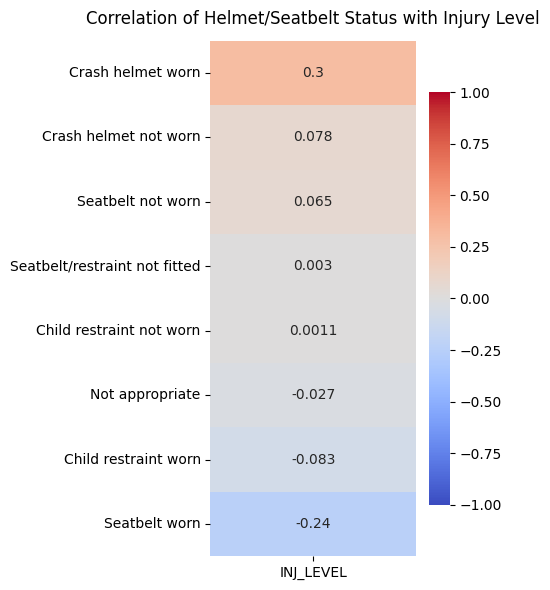

In [ ]:
helmet_encoded = pd.get_dummies(merged_df['HELMET_BELT_DESC'], prefix='HelmetBelt')
helmet_injury_df = pd.concat([helmet_encoded, merged_df['INJ_LEVEL']], axis=1)
helmet_corr = helmet_injury_df.corr()['INJ_LEVEL'].drop('INJ_LEVEL').sort_values(ascending=False)
helmet_corr.index = [col.replace('HelmetBelt_', '') for col in helmet_corr.index]

plt.figure(figsize=(5, 6))
sns.heatmap(helmet_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation of Helmet/Seatbelt Status with Injury Level', fontsize=12, pad=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Part 5: Bar heatmap - Seating Position vs Injury Levels

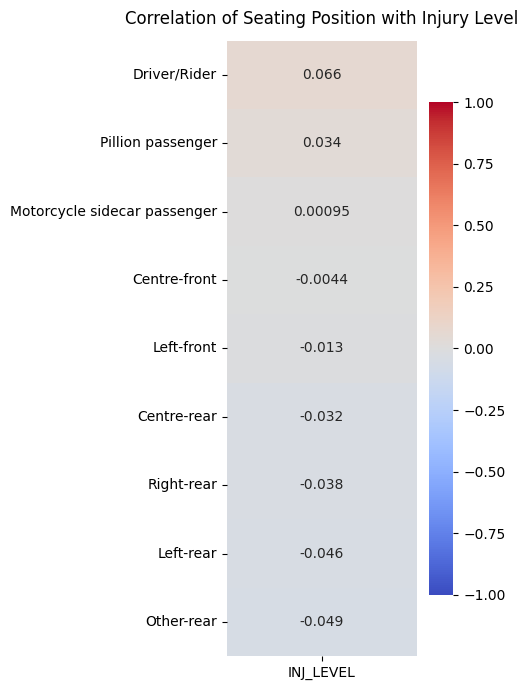

In [ ]:
seating_encoded = pd.get_dummies(merged_df['SEATING_POSITION_DESC'], prefix='SeatPos')
seating_injury_df = pd.concat([seating_encoded, merged_df['INJ_LEVEL']], axis=1)
seating_corr = seating_injury_df.corr()['INJ_LEVEL'].drop('INJ_LEVEL').sort_values(ascending=False)
seating_corr.index = [col.replace('SeatPos_', '') for col in seating_corr.index]

plt.figure(figsize=(5, 7))
sns.heatmap(seating_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation of Seating Position with Injury Level', fontsize=12, pad=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Part 6: Bar heatmap - Age Group vs Injury Levels

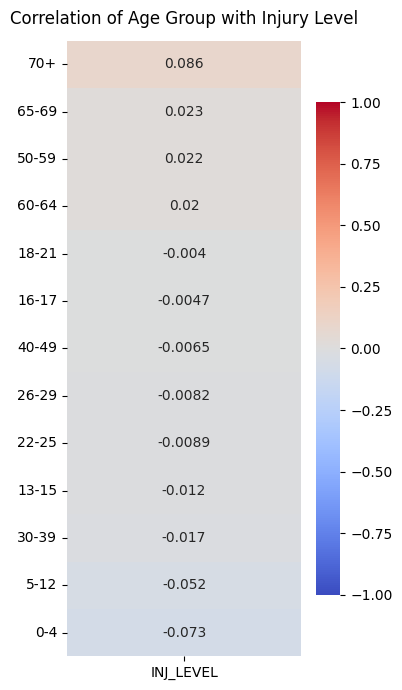

In [ ]:
age_encoded = pd.get_dummies(merged_df['AGE_GROUP'], prefix='AgeGroup')
age_injury_df = pd.concat([age_encoded, merged_df['INJ_LEVEL']], axis=1)
age_corr = age_injury_df.corr()['INJ_LEVEL'].drop('INJ_LEVEL').sort_values(ascending=False)
age_corr.index = [col.replace('AgeGroup_', '') for col in age_corr.index]

plt.figure(figsize=(4, 7))
sns.heatmap(age_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation of Age Group with Injury Level', fontsize=12, pad=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Part 7: Bar heatmap - Sex vs Injury Levels

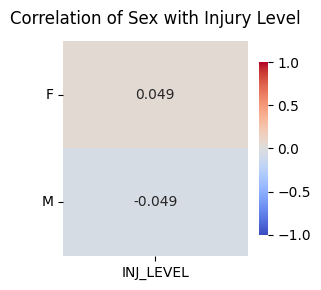

In [ ]:
sex_encoded = pd.get_dummies(merged_df['SEX'], prefix='Sex')
sex_encoded_injury_df = pd.concat([sex_encoded, merged_df['INJ_LEVEL']], axis=1)
sex_corr = sex_encoded_injury_df.corr()['INJ_LEVEL'].drop('INJ_LEVEL').sort_values(ascending=False)
sex_corr.index = sex_encoded.columns.str.replace('Sex_', '')
plt.figure(figsize=(3, 3))
sns.heatmap(sex_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation of Sex with Injury Level', fontsize=12, pad=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 4.4 Supervised Learning Models and Evaluation Component

Selecting sex, age group, vehicle manoeuvres, helmet belt usage and seating position as features to predict injury severity

In [ ]:
X_COLS = ['SEX_NUM', 'AGE_GROUP_NUM', 'VEHICLE_MOVEMENT', 'HELMET_BELT_WORN', 'SEATING_POSITION_NUM']
y_COL = 'INJ_LEVEL'

X = merged_df[X_COLS]
y = merged_df[y_COL]

Dividing data into training and testing sets using the Holdout method

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=30)

#### k-Nearest Neighbours (k-NN)
Using k-NN algorithm to train supervised Machine Learning Model

##### Choosing the optimal k-value using 10-fold cross validation


**This cell takes around 20 minutes to run, please uncomment this cell and the one below to run**


In [ ]:
# k_accuracy = {}

# n = 10
# nf_CV = KFold(n_splits=n, shuffle=True, random_state=30)

# for k in range(1, 36, 2):

#   knn_results = []


#   for train_idx, test_idx in nf_CV.split(X_train):
#     knn_X_train, knn_X_test = np.asarray(X_train.iloc[train_idx]), np.asarray(X_train.iloc[test_idx])
#     knn_y_train, knn_y_test = np.asarray(y_train.iloc[train_idx]), np.asarray(y_train.iloc[test_idx])

#     knn = KNN(n_neighbors=k)
#     knn.fit(knn_X_train, knn_y_train)

#     y_pred = knn.predict(knn_X_test)
#     knn_results.append(accuracy_score(knn_y_test, y_pred))

#   k_accuracy[k] = np.mean(knn_results)

In [ ]:
# optimal_k = max(k_accuracy, key=k_accuracy.get)
# print('Accuracy of optimal_k: ', round(k_accuracy[optimal_k], 4))


# for k, accuracy in k_accuracy.items():
#   print(f'{k}: {round(accuracy, 4)}')

Accuracy of optimal_k:  0.5257
1: 0.4364
3: 0.4716
5: 0.4855
7: 0.4901
9: 0.5031
11: 0.5097
13: 0.5141
15: 0.515
17: 0.5187
19: 0.5197
21: 0.5208
23: 0.5222
25: 0.5248
27: 0.5231
29: 0.5251
31: 0.5239
33: 0.5249
35: 0.5257


In [ ]:
# hard-coded based on experimentation results above
optimal_k = 35

knn = KNN(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=35)

##### Evaluating k-NN model

###### Confusion Matrix

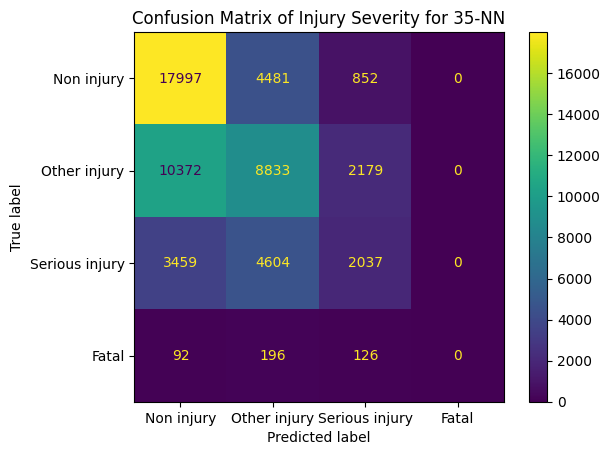

In [ ]:
cm_severity_label = {
    'Non injury': 0,
    'Other injury': 1,
    'Serious injury': 2,
    'Fatal': 3
}

knn_y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, knn_y_pred, labels=list(cm_severity_label.values()))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_severity_label.keys())

# Ensures that full integer values are shown
disp.plot(values_format='d')

plt.title('Confusion Matrix of Injury Severity for 35-NN')
plt.show()

###### Calculating accuracy, recall, precision and F1

In [ ]:
knn_accuracy = knn.score(X_test, y_test)
print('Accuracy: ', round(knn_accuracy, 4))

knn_recall = recall_score(y_test, knn_y_pred, average='weighted')
print('Recall: ', round(knn_recall, 4))

knn_precision = precision_score(y_test, knn_y_pred, average='weighted')
print('Precision: ', round(knn_precision, 4))

knn_f1 = f1_score(y_test, knn_y_pred, average='weighted')
print('F1-Score: ', round(knn_f1, 4))

Accuracy:  0.5227
Recall:  0.5227
Precision:  0.4987
F1-Score:  0.4971


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Decision Tree (DT)

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy')

##### Plotting a decision tree to predict injury severity

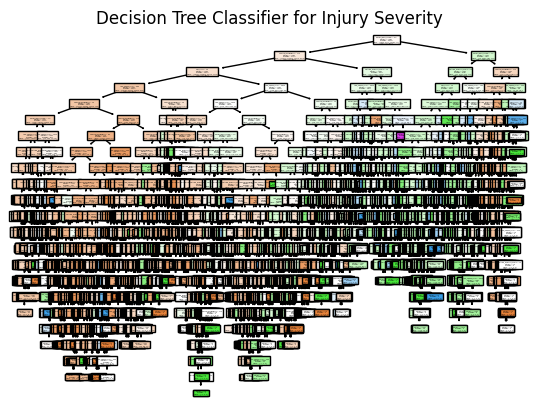

In [ ]:
categories = ['Non injury', 'Other injury', 'Serious injury', 'Fatal']

plot_tree(dt, feature_names=X_COLS, class_names=categories, filled=True)
plt.title("Decision Tree Classifier for Injury Severity")

plt.show()

##### Evaluating Decision Tree model

###### Confusion Matrix

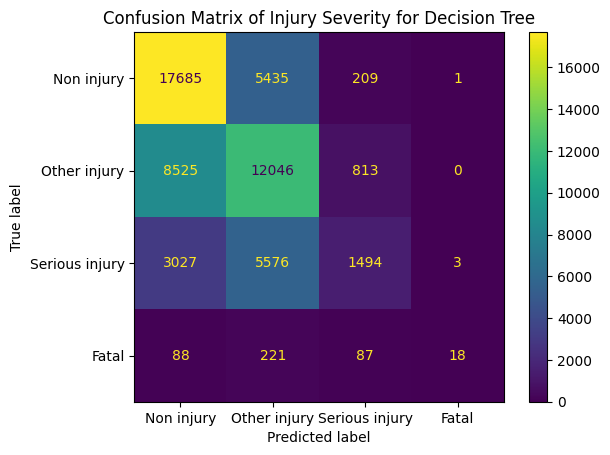

In [ ]:
cm_severity_label = {
    'Non injury': 0,
    'Other injury': 1,
    'Serious injury': 2,
    'Fatal': 3
}

dt_y_pred = dt.predict(X_test)

cm = confusion_matrix(y_test, dt_y_pred, labels=list(cm_severity_label.values()))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_severity_label.keys())

disp.plot(values_format='d')

plt.title('Confusion Matrix of Injury Severity for Decision Tree')
plt.show()

###### Calculating accuracy, recall, precision and F1

In [ ]:
dt_accuracy = dt.score(X_test, y_test)
print('Accuracy: ', round(dt_accuracy, 4))

dt_recall = recall_score(y_test, dt_y_pred, average='weighted')
print('Recall: ', round(dt_recall, 4))

dt_precision = precision_score(y_test, dt_y_pred, average='weighted')
print('Precision: ', round(dt_precision, 4))

dt_f1 = f1_score(y_test, dt_y_pred, average='weighted')
print('F1-Score: ', round(dt_f1, 4))

Accuracy:  0.5657
Recall:  0.5657
Precision:  0.5662
F1-Score:  0.5363


#### Evaluation of k-NN vs Decision Tree

##### 10-fold Cross Validation with 35-NN classifier

In [ ]:
n = 10

nf_CV = KFold(n_splits=n, shuffle=True, random_state=30)
knn_results = []

In [ ]:
for train_idx, test_idx in nf_CV.split(X_train):
  knn_X_train, knn_X_test = np.asarray(X_train.iloc[train_idx]), np.asarray(X_train.iloc[test_idx])
  knn_y_train, knn_y_test = np.asarray(y_train.iloc[train_idx]), np.asarray(y_train.iloc[test_idx])

  knn = KNN(n_neighbors=optimal_k)
  knn.fit(knn_X_train, knn_y_train)

  y_pred = knn.predict(knn_X_test)
  knn_results.append(accuracy_score(knn_y_test, y_pred))

In [ ]:
print('Average accuracy: ', round(np.mean(knn_results), 4))

Average accuracy:  0.5257


##### 10-fold cross validation with Decision Tree

In [ ]:
dt_results = []

In [ ]:
for train_idx, test_idx in nf_CV.split(X_train):
  dt_X_train, dt_X_test = np.asarray(X_train.iloc[train_idx]), np.asarray(X_train.iloc[test_idx])
  dt_y_train, dt_y_test = np.asarray(y_train.iloc[train_idx]), np.asarray(y_train.iloc[test_idx])

  dt = DecisionTreeClassifier(criterion='entropy')
  dt.fit(dt_X_train, dt_y_train)

  y_pred = dt.predict(dt_X_test)
  dt_results.append(accuracy_score(dt_y_test, y_pred))

In [ ]:
print('Average accuracy: ', round(np.mean(dt_results), 4))

Average accuracy:  0.5403


##### Imbalanced Classification in Injury Severity

In [ ]:
y_train.value_counts()

,count
INJ_LEVEL,
0,92915
1,85226
2,41100
3,1671


In [ ]:
y_test.value_counts()

,count
INJ_LEVEL,
0,23330
1,21384
2,10100
3,414


### 4.5 Data Clustering & Risk Profiling

#### KMeans and PCA Cluster analysis

##### Step 1: Get relevant columns

In [ ]:
important_cols = ['SEATING_POSITION','VEHICLE_MOVEMENT_DESC','HELMET_BELT_DESC','SEX',
            'AGE_GROUP_NUM']

filtered_df = merged_df[important_cols]

final_df = pd.get_dummies(filtered_df[important_cols], columns=important_cols)

##### Step 2: PCA

In [ ]:
pca = PCA(n_components=3)
x_pca = pca.fit_transform(final_df)

Elbow method for PCA data

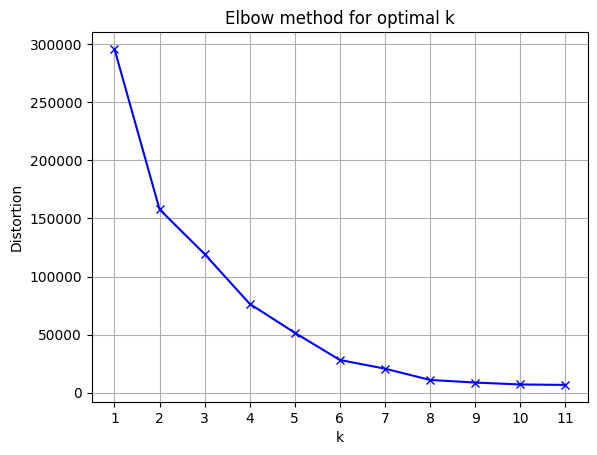

In [ ]:
distortions = []
k_range = range(1,12)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_pca)
    distortions.append(kmeans.inertia_)
plt.plot(k_range, distortions, 'bx-')
plt.title('Elbow method for optimal k')
plt.xlabel('k')
plt.xticks(k_range)
plt.ylabel('Distortion')
plt.grid(True)

Based on graph above, optimal value of k is chosen

In [ ]:
optimal_k = 16

##### Step 3: Clustering (e.g., KMeans)

In [ ]:
kmeans = KMeans(n_clusters= optimal_k, random_state=1464155)
cluster_labels = kmeans.fit_predict(x_pca)

##### Step 4: Assign cluster labels to data

In [ ]:
df_analysis = merged_df.copy()
df_analysis['cluster'] = cluster_labels

##### Step 5: Visualize PCA clusters

Unique cluster IDs

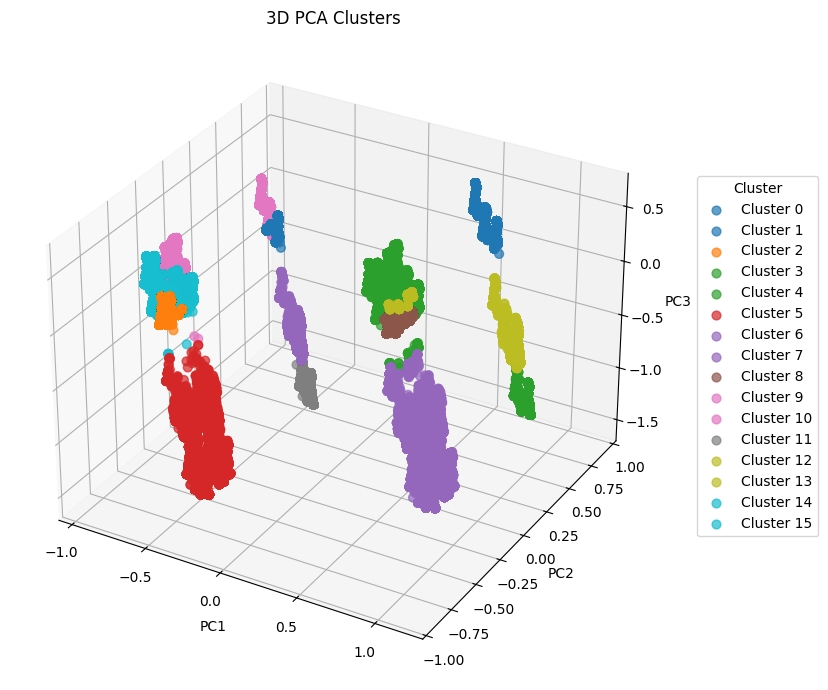

In [ ]:
unique_clusters = np.unique(cluster_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster separately with a label
for i, cluster in enumerate(unique_clusters):
    idx = cluster_labels == cluster
    ax.scatter(x_pca[idx, 0], x_pca[idx, 1], x_pca[idx, 2],
               c=[colors[i]], label=f'Cluster {cluster}', s=40, alpha=0.7)

ax.set_title("3D PCA Clusters")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend(title="Cluster")
ax.legend(title="Cluster", loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.show()

Variance of PC

In [ ]:
explained_var = pca.explained_variance_ratio_

print(f"Variance explained by each PC: {explained_var}")
print(f"Total variance explained: {explained_var.sum():.4f}")

Variance explained by each PC: [0.18544245 0.10723646 0.09025923]
Total variance explained: 0.3829


##### Step 6: Analyze injury level by cluster

In [ ]:
injury_by_cluster = df_analysis.groupby('cluster')['INJ_LEVEL'].value_counts(normalize=True).unstack().fillna(0)

#Summary stats for other features
summary = df_analysis.groupby('cluster').agg({
    'AGE_GROUP_NUM': 'mean',
    'SEX': lambda x: x.value_counts().idxmax(),
    'HELMET_BELT_DESC': lambda x: x.value_counts().idxmax(),
    'SEATING_POSITION_DESC': lambda x: x.value_counts().idxmax(),
    'VEHICLE_MOVEMENT_DESC': lambda x: x.value_counts().idxmax()
    # Add other features as needed
})

Injury level distribution by cluster

In [ ]:
injury_by_cluster

INJ_LEVEL,0,1,2,3
cluster,,,,
0,0.580111,0.290832,0.123944,0.005112
1,0.322630,0.477651,0.196275,0.003444
2,0.442371,0.332092,0.212735,0.012802
3,0.407121,0.416718,0.171749,0.004412
4,0.347555,0.438748,0.205846,0.007852
5,0.542068,0.322178,0.129265,0.006489
6,0.437560,0.395197,0.161692,0.005550
7,0.575242,0.324054,0.095792,0.004912
8,0.333039,0.440139,0.219186,0.007636


Cluster-wise summary statistics

In [ ]:
summary

,AGE_GROUP_NUM,SEX,HELMET_BELT_DESC,SEATING_POSITION_DESC,VEHICLE_MOVEMENT_DESC
cluster,,,,,
0,41.533220,M,Seatbelt worn,Driver/Rider,Going straight ahead
1,40.782238,F,Seatbelt worn,Driver/Rider,Going straight ahead
2,40.156487,M,Seatbelt worn,Driver/Rider,Turning right
3,42.294156,F,Seatbelt worn,Driver/Rider,Turning left
4,39.183568,F,Seatbelt worn,Left-front,Going straight ahead
5,24.920276,M,Seatbelt worn,Left-front,Out of control
6,30.866908,F,Seatbelt worn,Left-front,Turning right
7,15.682577,M,Seatbelt worn,Left-rear,Going straight ahead
8,39.509214,F,Seatbelt worn,Driver/Rider,Turning right
